# **Del texto al dato: cómo entienden las máquinas el lenguaje humano con Python**

**Fichero de experimentación y mejor comprensión del PLN a través de NLTK (Natural Language Toolkit - NLTK) - Vader**

Este fichero Jupyter Notebook, es una sub-parte del presente taller de **Procesamiento del lenguage natural (NLP)** a través del **análisis de sentimiento y texto**, para experimentación y **exploración más profunda** con el algorítmo Vader de la biblioteca de Python NLTK a fin de **entender de dónde vienen los números** que llevan al algorítmo a calcular, darnos unos resultados u otros.

https://github.com/cristinasprogrammingadventure/PyDay-2025_workshop-Del-Texto-al-Dato_NLP

### Librerías básicas (manejo de datos y entorno)

In [24]:
# ==== LIBRERÍAS BÁSICAS ====

import pandas as pd        # manejo de datos en tablas (DataFrames)
import numpy as np         # cálculos numéricos y arrays
import math
import re                  # expresiones regulares (limpieza de texto)
import string              # manejo de puntuación


### Librerías para procesamiento de texto (NLP / análisis de sentimiento)

In [25]:
# ==== LIBRERÍAS DE PROCESAMIENTO DE TEXTO ====

######################  NRC Emotion Lexicon
# --- NLTK: herramientas clásicas de NLP ---
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import namedtuple, OrderedDict

stopwords_es = stopwords.words("spanish")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Librerías para visualización

In [26]:
# ==== LIBRERÍAS DE VISUALIZACIÓN ====

import matplotlib.pyplot as plt      # gráficos base
import seaborn as sns                # gráficos de alto nivel (opcional)
from wordcloud import WordCloud      # nubes de palabras

# --- diagramas específicos ---
# !pip install matplotlib-venn
# from matplotlib_venn import venn2   # comparar vocabulario entre textos

# --- estilo gráfico ---
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")


### **SIMULACRO de pipeline paso a paso con NLTK - Vader !!!**

Se han creado unas celdas didácticas que muestran

**paso a paso cómo VADER procesa** una frase (**tokeniza, busca en el léxico, aplica reglas** — negación, intensificadores, mayúsculas, signos de exclamación—, suma y normaliza con la fórmula compound).

La función está pensada para usarla en un Colab Notebook con ***nltk.sentiment.SentimentIntensityAnalyzer***

**Explicación de lo que hace:**

- Tokeniza la frase con un método simple (palabras y signos).

- Busca cada token en analyzer.lexicon (el diccionario VADER real). Si está, toma su score base; si no, base=0.

- Aplica reglas didácticas como lo hace Vader:

  - Intensificadores (boosters) que multiplican la palabra.

  - Negaciones que invierten/atenuan.

  - ALL CAPS (mayúsculas) aumentan intensidad.

  - Exclamaciones en el texto aumentan intensidad.

  - Contraste con “but / pero”: multiplica los elementos posteriores (peso más alto para lo posterior).

  - Calcula el adjusted_score por token = base × modifier.

  - Suma los adjusted_score y aplica la fórmula del compound para normalizar entre −1 y +1.

  - Muestra el **compound** que devuelve **analyzer.polarity_scores(text)** para comparar textos de dferentes tamaños.


**Código — análisis paso a paso (VADER-like, pero algo más sencillo)**

- El código es simplificado: **replica las reglas más relevantes** de VADER para que se vea paso a paso lo que ocurre.

- VADER real tiene ajustes y detalles más finos (p. ej. constantes ligeramente distintas, tratamiento más preciso de mayúsculas, puntuación, emoticonos y contracciones).

- En español la mayor parte de tokens no aparecen en el lexicon
  - found = False para muchas palabras (VADER no es recomendable para español sin traducir).

In [17]:
# === Ejemplos con los textos en español y traducidos al inglés ===

texto1 = "Volveré ! El servicio es excelente y la comida, deliciosa. El ambiente es agradable. El personal muy atento. Excelente ubicación. Personalmente, me agrada mucho. Sin duda volveré pronto."
texto2 = "La espera fue larga y la comida llegó fría. El servicio fue descuidado y la experiencia en general bastante decepcionante."
texto3 = "I will return! The service is excellent and the food is delicious. The atmosphere is pleasant. The staff is very attentive. Excellent location. Personally, I like it a lot. I will definitely be back soon."
texto4 = "OMG !!! The wait was TOO LONG and the food arrived cold. The service was careless and the overall experience was quite disappointing."
texto5 = "OMG, OH MY GOD !!! The wait was TOO LONG and the food arrived cold. The service was careless and the overall experience was quite disappointing, but my kids love it."  # + parte contrastante "but my kids love it"


In [19]:
# Pipeline simplificado al estilo Vader

analyzer = SentimentIntensityAnalyzer()

# Reglas/recursos didácticos (pequeño subconjunto de intensificadores y negaciones)
BOOSTER_DICT = {
    "very": 1.5, "extremely": 2.0, "absolutely": 1.8, "really": 1.5,
    "quite": 1.2, "slightly": 0.5, "barely": 0.5
}
NEGATE = {"no", "not", "never", "n't", "none", "nunca", "jamás", "sin"}   # incluimos algunos en español para demo
CONTRASTIVE = {"but", "pero", "aunque", "sin embargo", "however", "nevertheless"}

# Estructura de salida por token
TokenInfo = namedtuple("TokenInfo", ["token", "found", "base_score", "modifier", "adjusted_score", "notes"])

def _simple_tokenize(text):
    # tokenizador simple: separa por espacios y signos, mantiene palabras
    text = text.strip()
    # conservar ¡¿? etc? simplificamos
    tokens = re.findall(r"\w+|[^\w\s]", text, flags=re.UNICODE)
    return tokens

def compute_compound_from_list(scores):
    """Aplica la fórmula compound = sum(x) / sqrt(sum(x^2)+15)"""
    sum_x = sum(scores)
    sum_x2 = sum([x*x for x in scores])
    compound = sum_x / math.sqrt(sum_x2 + 15.0)
    # limitar por seguridad
    if compound > 1: compound = 1.0
    if compound < -1: compound = -1.0
    return compound

def vader_stepwise(text, analyzer=analyzer, show_details=True):
    """
    Analiza la frase paso a paso con lógica estilo VADER (didáctica, simplificada).
    Devuelve: list(TokenInfo), suma, compound_manual, compound_analyzer
    """
    tokens = _simple_tokenize(text)
    # lower tokens para lookup, pero conservamos info original
    lowered = [t.lower() for t in tokens]

    # detectar si hay mayúsculas que sugieran énfasis (más de la mitad de letras del token en mayúscula)
    def caps_emphasis(tok):
        letters = [c for c in tok if c.isalpha()]
        if not letters:
            return False
        upper_count = sum(1 for c in letters if c.isupper())
        return upper_count > 0 and (upper_count / len(letters)) > 0.5

    # Recorremos tokens y construimos info
    infos = []
    for i, tok in enumerate(tokens):
        low = lowered[i]
        base = None
        found = False
        notes = []
        # buscar en lexicon (vader lexicon está en analyzer.lexicon)
        if low in analyzer.lexicon:
            base = analyzer.lexicon[low]
            found = True
            notes.append("lexicon")
        else:
            # probar lematizar/strip de sufijos simples (didáctico)
            # ejemplo: "delicious" ok, "deliciosa" no → no lo convertimos automáticamente aquí
            base = 0.0
        # start modifier = 1.0 (sin cambio)
        modifier = 1.0

        # chequeo de intensificadores en ventana previa (2 tokens previos)
        window_start = max(0, i-3)
        for j in range(window_start, i):
            w = lowered[j]
            if w in BOOSTER_DICT:
                modifier *= BOOSTER_DICT[w]
                notes.append(f"booster({w})")

        # chequeo de negación en ventana previa (3 tokens)
        neg_found = any(w in NEGATE for w in lowered[max(0,i-3):i])
        if neg_found:
            modifier *= -0.74   # VADER aplica un factor de inversión aproximado (didáctico)
            notes.append("negation")

        # mayúsculas (énfasis)
        if caps_emphasis(tokens[i]):
            modifier *= 1.5
            notes.append("ALLCAPS")

        # puntuación de énfasis: exclamaciones en el texto aumentan (global)
        exclamations = text.count("!")
        if exclamations > 0:
            # factor ligero por exclamaciones (didáctico)
            modifier *= (1 + 0.05 * min(exclamations, 4))
            notes.append(f"exclaim({exclamations})")

        # calcular adjusted score: base * modifier
        adj = base * modifier if found else 0.0

        infos.append(TokenInfo(token=tok, found=found, base_score=base, modifier=modifier, adjusted_score=adj, notes=", ".join(notes)))

    # regla contrastiva (pero / but): dar mayor peso a lo posterior a "but"/"pero"
    # estrategia didáctica: si se encuentra 'but' o 'pero', multiplica por 1.5 los scores posteriores

    for i, info in enumerate(infos):
        if info.token.lower() in CONTRASTIVE:
            # aplicar factor a los tokens posteriores hasta final
            for k in range(i+1, len(infos)):
                if infos[k].found:
                    new_adj = infos[k].adjusted_score * 1.5
                    infos[k] = infos[k]._replace(adjusted_score=new_adj, notes=(infos[k].notes + ", contrastive" if infos[k].notes else "contrastive"))

    # ahora sumamos los adjusted_score y aplicamos fórmula compound
    adjusted_scores = [inf.adjusted_score for inf in infos]

    # obtener manual sum only of non-zero
    sum_adjusted = sum(adjusted_scores)
    compound_manual = compute_compound_from_list(adjusted_scores)

    # obtener VADER analyzer compound (para comparar)
    try:
        vader_scores = analyzer.polarity_scores(text)
        compound_analyzer = vader_scores.get("compound", None)
    except Exception:
        compound_analyzer = None

    if show_details:
        # mostrar tabla
        print(f"Texto: {text}\n")
        print(f"{'token':15s} {'found':7s} {'base':8s} {'modifier':9s} {'adj':8s}  notes")
        print("-"*80)
        for inf in infos:
            base_s = f"{inf.base_score:.3f}" if inf.found else "---"
            mod_s = f"{inf.modifier:.3f}"
            adj_s = f"{inf.adjusted_score:.3f}"
            print(f"{inf.token:15s} {str(inf.found):7s} {base_s:8s} {mod_s:9s} {adj_s:8s}  {inf.notes}")
        print("-"*80)
        print(f"Sum adjusted scores: {sum_adjusted:.3f}")
        print(f"Compound (manual formula): {compound_manual:.4f}")
        print(f"Compound (analyzer.polarity_scores): {compound_analyzer}\n")

                # === MOSTRAR NEG / NEU / POS justo debajo ===
        if vader_scores:
            print("VADER breakdown")
            print(f"  NEG: {vader_scores['neg']:.3f}")
            print(f"  NEU: {vader_scores['neu']:.3f}")
            print(f"  POS: {vader_scores['pos']:.3f}")
            print("-"*80 + "\n")


    return infos, sum_adjusted, compound_manual, compound_analyzer


In [20]:
# === Obtener POS, NEG, NEU y compound para cada texto ===

textos = {"texto1": texto1, "texto2": texto2, "texto3": texto3, "texto4": texto4, "texto5": texto5}
print("\n=== Resultados VADER: NEG / NEU / POS / COMPOUND ===\n")

for nombre, txt in textos.items():
    scores = analyzer.polarity_scores(txt)

    # le decimos de imprimir el nombre del texto y (si necesario) el contenido texto mismo {txt}
    print(f"{nombre}: \n{txt}")
    print(f"  NEG: {scores['neg']:.3f}")
    print(f"  NEU: {scores['neu']:.3f}")
    print(f"  POS: {scores['pos']:.3f}")
    print(f"  COMPOUND: {scores['compound']:.4f}")
    print("-" * 50)



=== Resultados VADER: NEG / NEU / POS / COMPOUND ===

texto1: 
Volveré ! El servicio es excelente y la comida, deliciosa. El ambiente es agradable. El personal muy atento. Excelente ubicación. Personalmente, me agrada mucho. Sin duda volveré pronto.
  NEG: 0.135
  NEU: 0.865
  POS: 0.000
  COMPOUND: -0.5983
--------------------------------------------------
texto2: 
La espera fue larga y la comida llegó fría. El servicio fue descuidado y la experiencia en general bastante decepcionante.
  NEG: 0.000
  NEU: 1.000
  POS: 0.000
  COMPOUND: 0.0000
--------------------------------------------------
texto3: 
I will return! The service is excellent and the food is delicious. The atmosphere is pleasant. The staff is very attentive. Excellent location. Personally, I like it a lot. I will definitely be back soon.
  NEG: 0.000
  NEU: 0.553
  POS: 0.447
  COMPOUND: 0.9646
--------------------------------------------------
texto4: 
OMG !!! The wait was TOO LONG and the food arrived cold. The servi

### **Experimento con textos en español**

In [13]:
# Ejecutar resultados del pipeline
vader_stepwise(texto1)

Texto: Volveré ! El servicio es excelente y la comida, deliciosa. El ambiente es agradable. El personal muy atento. Excelente ubicación. Personalmente, me agrada mucho. Sin duda volveré pronto.

token           found   base     modifier  adj       notes
--------------------------------------------------------------------------------
Volveré         False   ---      1.050     0.000     exclaim(1)
!               False   ---      1.050     0.000     exclaim(1)
El              False   ---      1.050     0.000     exclaim(1)
servicio        False   ---      1.050     0.000     exclaim(1)
es              False   ---      1.050     0.000     exclaim(1)
excelente       False   ---      1.050     0.000     exclaim(1)
y               False   ---      1.050     0.000     exclaim(1)
la              False   ---      1.050     0.000     exclaim(1)
comida          False   ---      1.050     0.000     exclaim(1)
,               False   ---      1.050     0.000     exclaim(1)
deliciosa       False   -

([TokenInfo(token='Volveré', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='!', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='El', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='servicio', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='es', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='excelente', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='y', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='la', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='comida', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),

In [14]:
# Ejecutar resultados del pipeline
vader_stepwise(texto2)

Texto: La espera fue larga y la comida llegó fría. El servicio fue descuidado y la experiencia en general bastante decepcionante.

token           found   base     modifier  adj       notes
--------------------------------------------------------------------------------
La              False   ---      1.000     0.000     
espera          False   ---      1.000     0.000     
fue             False   ---      1.000     0.000     
larga           False   ---      1.000     0.000     
y               False   ---      1.000     0.000     
la              False   ---      1.000     0.000     
comida          False   ---      1.000     0.000     
llegó           False   ---      1.000     0.000     
fría            False   ---      1.000     0.000     
.               False   ---      1.000     0.000     
El              False   ---      1.000     0.000     
servicio        False   ---      1.000     0.000     
fue             False   ---      1.000     0.000     
descuidado      False   ---

([TokenInfo(token='La', found=False, base_score=0.0, modifier=1.0, adjusted_score=0.0, notes=''),
  TokenInfo(token='espera', found=False, base_score=0.0, modifier=1.0, adjusted_score=0.0, notes=''),
  TokenInfo(token='fue', found=False, base_score=0.0, modifier=1.0, adjusted_score=0.0, notes=''),
  TokenInfo(token='larga', found=False, base_score=0.0, modifier=1.0, adjusted_score=0.0, notes=''),
  TokenInfo(token='y', found=False, base_score=0.0, modifier=1.0, adjusted_score=0.0, notes=''),
  TokenInfo(token='la', found=False, base_score=0.0, modifier=1.0, adjusted_score=0.0, notes=''),
  TokenInfo(token='comida', found=False, base_score=0.0, modifier=1.0, adjusted_score=0.0, notes=''),
  TokenInfo(token='llegó', found=False, base_score=0.0, modifier=1.0, adjusted_score=0.0, notes=''),
  TokenInfo(token='fría', found=False, base_score=0.0, modifier=1.0, adjusted_score=0.0, notes=''),
  TokenInfo(token='.', found=False, base_score=0.0, modifier=1.0, adjusted_score=0.0, notes=''),
  Tok

### **Experimento con textos en inglés**

In [21]:
# Ejecutar resultados del pipeline
vader_stepwise(texto3)

Texto: I will return! The service is excellent and the food is delicious. The atmosphere is pleasant. The staff is very attentive. Excellent location. Personally, I like it a lot. I will definitely be back soon.

token           found   base     modifier  adj       notes
--------------------------------------------------------------------------------
I               False   ---      1.575     0.000     ALLCAPS, exclaim(1)
will            False   ---      1.050     0.000     exclaim(1)
return          False   ---      1.050     0.000     exclaim(1)
!               False   ---      1.050     0.000     exclaim(1)
The             False   ---      1.050     0.000     exclaim(1)
service         False   ---      1.050     0.000     exclaim(1)
is              False   ---      1.050     0.000     exclaim(1)
excellent       True    2.700    1.050     2.835     lexicon, exclaim(1)
and             False   ---      1.050     0.000     exclaim(1)
the             False   ---      1.050     0.000     

([TokenInfo(token='I', found=False, base_score=0.0, modifier=1.5750000000000002, adjusted_score=0.0, notes='ALLCAPS, exclaim(1)'),
  TokenInfo(token='will', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='return', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='!', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='The', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='service', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='is', found=False, base_score=0.0, modifier=1.05, adjusted_score=0.0, notes='exclaim(1)'),
  TokenInfo(token='excellent', found=True, base_score=2.7, modifier=1.05, adjusted_score=2.8350000000000004, notes='lexicon, exclaim(1)'),
  TokenInfo(token='and', found=False, base_score=0.0, modifier=1.

In [22]:
# Ejecutar resultados del pipeline
vader_stepwise(texto4)

Texto: OMG !!! The wait was TOO LONG and the food arrived cold. The service was careless and the overall experience was quite disappointing.

token           found   base     modifier  adj       notes
--------------------------------------------------------------------------------
OMG             False   ---      1.725     0.000     ALLCAPS, exclaim(3)
!               False   ---      1.150     0.000     exclaim(3)
!               False   ---      1.150     0.000     exclaim(3)
!               False   ---      1.150     0.000     exclaim(3)
The             False   ---      1.150     0.000     exclaim(3)
wait            False   ---      1.150     0.000     exclaim(3)
was             False   ---      1.150     0.000     exclaim(3)
TOO             False   ---      1.725     0.000     ALLCAPS, exclaim(3)
LONG            False   ---      1.725     0.000     ALLCAPS, exclaim(3)
and             False   ---      1.150     0.000     exclaim(3)
the             False   ---      1.150     0.000   

([TokenInfo(token='OMG', found=False, base_score=0.0, modifier=1.7249999999999999, adjusted_score=0.0, notes='ALLCAPS, exclaim(3)'),
  TokenInfo(token='!', found=False, base_score=0.0, modifier=1.15, adjusted_score=0.0, notes='exclaim(3)'),
  TokenInfo(token='!', found=False, base_score=0.0, modifier=1.15, adjusted_score=0.0, notes='exclaim(3)'),
  TokenInfo(token='!', found=False, base_score=0.0, modifier=1.15, adjusted_score=0.0, notes='exclaim(3)'),
  TokenInfo(token='The', found=False, base_score=0.0, modifier=1.15, adjusted_score=0.0, notes='exclaim(3)'),
  TokenInfo(token='wait', found=False, base_score=0.0, modifier=1.15, adjusted_score=0.0, notes='exclaim(3)'),
  TokenInfo(token='was', found=False, base_score=0.0, modifier=1.15, adjusted_score=0.0, notes='exclaim(3)'),
  TokenInfo(token='TOO', found=False, base_score=0.0, modifier=1.7249999999999999, adjusted_score=0.0, notes='ALLCAPS, exclaim(3)'),
  TokenInfo(token='LONG', found=False, base_score=0.0, modifier=1.7249999999999

In [23]:
# Ejecutar resultados del pipeline
vader_stepwise(texto5)

Texto: OMG, OH MY GOD !!! The wait was TOO LONG and the food arrived cold. The service was careless and the overall experience was quite disappointing, but my kids love it.

token           found   base     modifier  adj       notes
--------------------------------------------------------------------------------
OMG             False   ---      1.725     0.000     ALLCAPS, exclaim(3)
,               False   ---      1.150     0.000     exclaim(3)
OH              False   ---      1.725     0.000     ALLCAPS, exclaim(3)
MY              False   ---      1.725     0.000     ALLCAPS, exclaim(3)
GOD             True    1.100    1.725     1.897     lexicon, ALLCAPS, exclaim(3)
!               False   ---      1.150     0.000     exclaim(3)
!               False   ---      1.150     0.000     exclaim(3)
!               False   ---      1.150     0.000     exclaim(3)
The             False   ---      1.150     0.000     exclaim(3)
wait            False   ---      1.150     0.000     exclaim(3)
w

([TokenInfo(token='OMG', found=False, base_score=0.0, modifier=1.7249999999999999, adjusted_score=0.0, notes='ALLCAPS, exclaim(3)'),
  TokenInfo(token=',', found=False, base_score=0.0, modifier=1.15, adjusted_score=0.0, notes='exclaim(3)'),
  TokenInfo(token='OH', found=False, base_score=0.0, modifier=1.7249999999999999, adjusted_score=0.0, notes='ALLCAPS, exclaim(3)'),
  TokenInfo(token='MY', found=False, base_score=0.0, modifier=1.7249999999999999, adjusted_score=0.0, notes='ALLCAPS, exclaim(3)'),
  TokenInfo(token='GOD', found=True, base_score=1.1, modifier=1.7249999999999999, adjusted_score=1.8975, notes='lexicon, ALLCAPS, exclaim(3)'),
  TokenInfo(token='!', found=False, base_score=0.0, modifier=1.15, adjusted_score=0.0, notes='exclaim(3)'),
  TokenInfo(token='!', found=False, base_score=0.0, modifier=1.15, adjusted_score=0.0, notes='exclaim(3)'),
  TokenInfo(token='!', found=False, base_score=0.0, modifier=1.15, adjusted_score=0.0, notes='exclaim(3)'),
  TokenInfo(token='The', fo

## **Observaciones y explicaciones:** usando el ejemplo del ***texto5***:

  ***"OMG, OH MY GOD !!! The wait was TOO LONG and the food arrived cold. The service was careless and the overall experience was quite disappointing, but my kids love it."***

- Los signos “**!**” y otros signos y palabras → “**found = False**”
  - NO significa que “VADER no los reconozca”
  - significa que **no está** en el ***lexicon*** de **palabras con sentimiento**
  - =>  **no aportan sentimiento propio** → base = 0 y adjusted = 0
  - Sí que **las reconoce** y pueden acaban **afectando el cálculo final** ('interpretación') **si afectan el modifier**

### **Exclamation (!)**

En la tabla resultante siempre **aparece 1.15 cuando hay un “nivel bajo” de excitación** aplicando así este valor moderado (≈ +15%) cuando no hay refuerzo especial ni palabras en mayúsculas.

VADER aumenta la intensidad según cuántos “!” encuentre (máx. 4):

- Luego, cada '**!**' suma → +0.292
- si hay 4 -> +0.292 x 4 = 1,168

#### **QUÉ ES “modifier”**
  
  - modifier refleja el **estado de intensidad acumulado**, el **factor multiplicador final** que se aplica al *base_score* de cada *token* con **sentimiento**, que luego se aplicaría a la **siguiente palabra con sentimiento**, si existiera

### **QUÉ son los Booster words (intensificadores/atenuadores)**

  - Ej.: very, extremely, quite, barely…
Modifican ±10% o ±15% el valor de la palabra a la derecha.

    quite → +0.15 sobre palabras positivas

    quite → −0.15 sobre palabras negativas

    => cuando aparece “quite” antes de disappointing se aplica: modifier = 1 + 0.15 = 1.15

    => si hay signos de exclamación (!), se suma más

  - Ejemplo:

    **El resultado !     False   --->   1.150 ->  0.000 ->  exclaim(3) Significa:**

    - found=False → “!” no es una palabra del léxico emocional, pero contará como amplificador.

    - modifier=1.150 → los signos de exclamación están amplificando el sentimiento de palabras cercanas.

    - adjusted_score=0.000 → al no tener base_score, ellos solos no suman ni restan.

    - exclaim(3) → se detectaron 3 signos “!”, y VADER eleva la excitación general del texto.

### **QUÉ son ALL CAPS (*capital letters* - todo mayúsculas)**

  - Ej.: OMG, OH, MY, TOO, LONG

Veamos la línea:

TokenInfo(token='**GOD**', found=True, base_score=1.1, modifier=1.7249, adjusted_score=1.8975, notes='lexicon, ALLCAPS, exclaim(3)'

- “OMG, OH, MY” no están en el léxico → no suman nada

- Pero sí reciben modifiers (mayúsculas, exclamaciones), aunque multiplican 0 → 0.

- El único término que contribuye a la emoción de ese bloque es *GOD*, por eso genera una 'positividad artificial'.


  - Ej.: POR QUÉ "**OMG** / **OH MY GOD**" dispara valores raros

    - “**GOD**” está en el **léxico como positivo** (valor base +1.1)

    - Está en mayúsculas → se refuerza modifier => modifier + 0.733 (≈ **+73% de intensidad**)

    - Va seguido de “!!!” → se refuerza más
    - Los modifiers de *GOD* son 1.725 (≈ 1 + 0.733).


    - **¿Cuál es el peso total del token “GOD” en este texto**?

      +1.10 → sentimiento base en el léxico

      ×1.725 → amplificación por mayúsculas y signos de exclamación

      = 1.10 × 1.725 = 1.8975

      = 1.90 → puntuación final ajustada (positivo artificial)


### **Contrast (“but”, “however”)**

- Cuando aparece “but”, VADER reduce la intensidad del sentimiento de la parte antes de “but” (*pero*)

- aumenta la intensidad de lo que está después

- Eso explica por qué ***love recibe “contrastive***”.

- Por eso love termina con modifier 1.15 pero su efecto domina en el compound final

Veamos la línea :

TokenInfo(token='**love**', found=**True**, **base_score=3.2**, **modifier=1.15**, **adjusted_score=5.52**, **notes**='lexicon, exclaim(3), contrastive

  -   podemos calcular 3.2 * 1.15 = 3.68 (no 5.520 !) -> Esto solo aplica el modifier local (mayúsculas, exclamaciones, boosters)
  - falta un paso más del algoritmo:
    - aplicar el “**contrastive shift**” por ***BUT*** (“***Pseudorule of contrastive conjunctions***”)
      - VADER **reduce el peso de los sentimientos anteriores** y **aumenta el sentimiento posterior** aproximadamente x1.5, por lo que tendremos:
      - **base_score** x **modifier** x **contrastive boost** = **adjusted_score** (peso real de la palabra)

        
      - Con ello vemos que aumenta el peso del sentimiento que viene después del “but”

    - ¿Cuál es el peso total del **token “love”** en **este texto**?

        3.20 → sentimiento base de “love” en el léxico

        ×1.15 → amplificación por contexto (mayúsculas, exclamación, etc.)

        ×1.50 → boost adicional porque viene después de “but” (regla contrastiva)

      = 3.2 × 1.15 × 1.5 = 5.52  
      
      = 5.52 → puntuación final ajustada

Su peso es 5.52, dominando el análisis porque aparece después de “but”,
y VADER está **diseñado para priorizar “la cláusula final”** en frases **contrastivas** siendo una **regla lingüística preprogramada** del inglés, si tenemos “It was bad, but I loved it” → **el sentimiento final domina**, no siendo solo un matiz.

### **RESUMEN DE REGLAS AFECTANDO AL CÁLCULO GENERAL**

**modifier** de las palabras => **combinación de**:

- Booster words
- ALL CAPS
- Exclamation
- Reglas de contraste (“but”, "however")
- Negación (no aparece en este texto, pero podrá ser "***not***" como en "***not nice***")
- Algunas otras reglas y matices


## **Algunas visualizaciones de los resultados**

- A continuación mostramos unas gráficas con los textos más positivos, negativos o neutros.
- Demostrar cómo VADER cambia mucho según el idioma, o una frase contrastiva como “but my kids love it”.

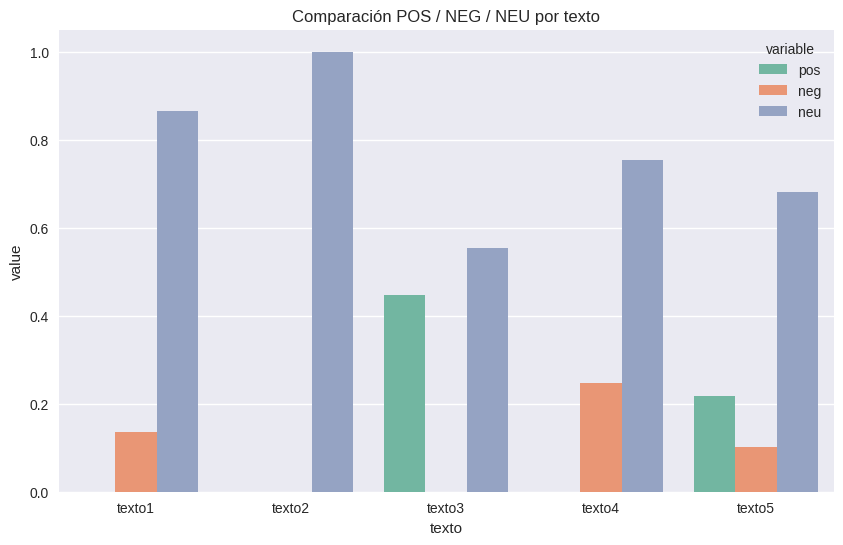

In [27]:
df = pd.DataFrame([
    {"texto": "texto1", **analyzer.polarity_scores(texto1)},
    {"texto": "texto2", **analyzer.polarity_scores(texto2)},
    {"texto": "texto3", **analyzer.polarity_scores(texto3)},
    {"texto": "texto4", **analyzer.polarity_scores(texto4)},
    {"texto": "texto5", **analyzer.polarity_scores(texto5)},
])

df_melt = df.melt(id_vars="texto", value_vars=["pos", "neg", "neu"])

plt.figure(figsize=(10,6))
sns.barplot(data=df_melt, x="texto", y="value", hue="variable")
plt.title("Comparación POS / NEG / NEU por texto")
plt.show()

- Lo mismo pero con el valor "compound" de cada texto

/tmp/ipython-input-736179220.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(orden)


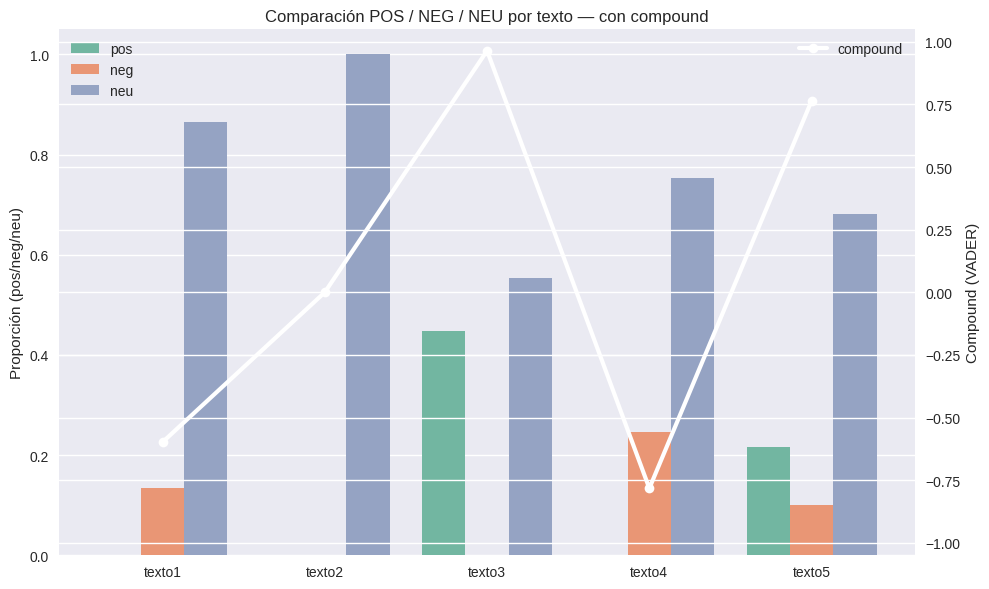

In [48]:
# Orden consistente
orden = df["texto"].tolist()

# Melt para barras (pos/neg/neu)
df_melt = df.melt(id_vars="texto", value_vars=["pos", "neg", "neu"], var_name="sent_type", value_name="value")

# Configurar figura
plt.figure(figsize=(10,6))
ax = plt.gca()

# Barras POS/NEG/NEU
sns.barplot(data=df_melt, x="texto", y="value", hue="sent_type", order=orden, ax=ax)

# Añadir eje secundario para compound
ax2 = ax.twinx()
x_positions = np.arange(len(orden))

# Tomar compounds en el mismo orden
compounds = df.set_index("texto").loc[orden, "compound"].values

# Dibujar línea y markers para compound (eje derecho)
ax2.plot(x_positions, compounds, color="white", marker="o", linestyle='-', linewidth=3, label="compound")
ax2.set_ylim(-1.05, 1.05)
ax2.set_ylabel("Compound (VADER)")

# Ajustes estéticos
ax.set_title("Comparación POS / NEG / NEU por texto — con compound")
ax.set_ylabel("Proporción (pos/neg/neu)")
ax.set_xlabel("")
ax.set_xticklabels(orden)
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


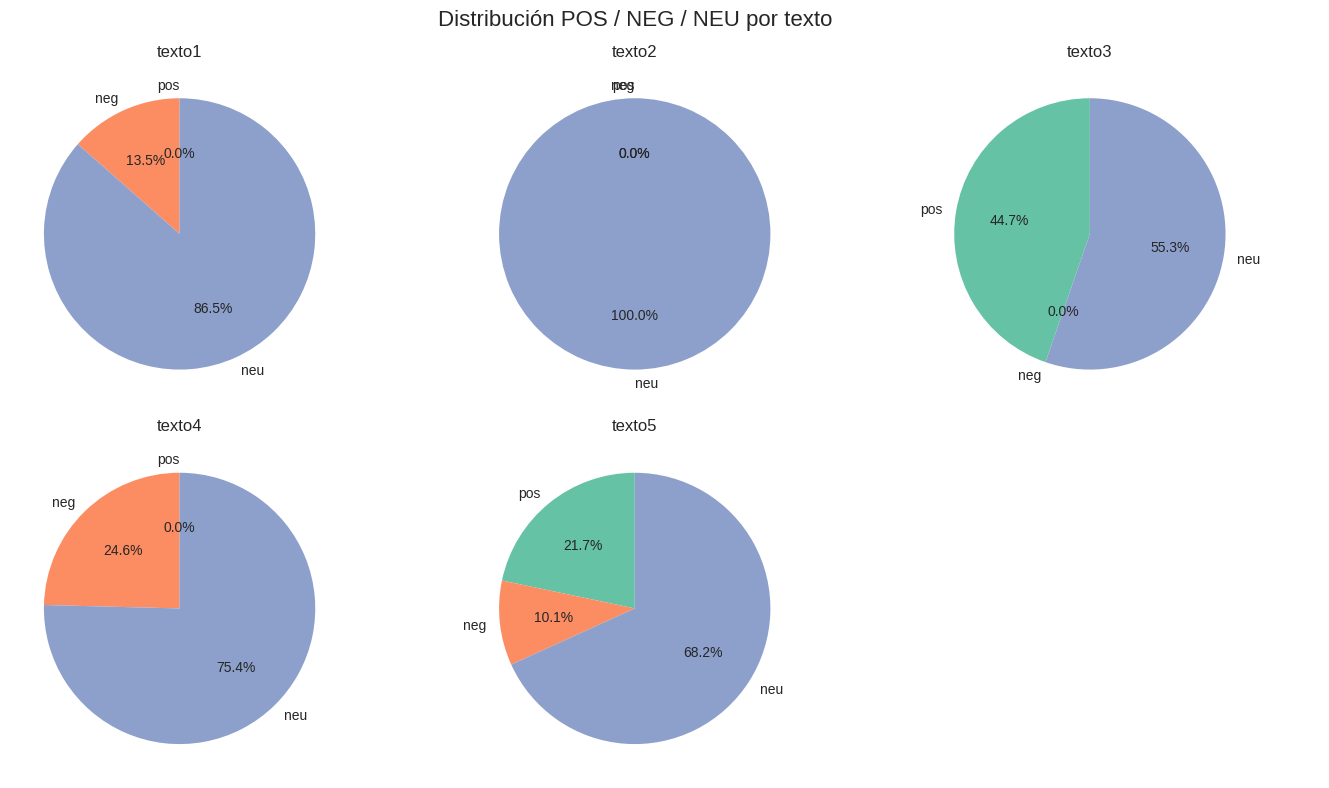

In [49]:
# Solo columnas de interés
variables = ["pos", "neg", "neu"]

# Configurar figura: 2 filas × 3 columnas (uno queda vacío)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

colors = ["#66c2a5", "#fc8d62", "#8da0cb"]   # verde, rojo, azul suave

for i, (idx, row) in enumerate(df.iterrows()):
    ax = axes[i]
    valores = [row[v] for v in variables]

    ax.pie(
        valores,
        labels=variables,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors
    )
    ax.set_title(row["texto"], fontsize=12)

# El último subplot queda vacío → lo apagamos
axes[-1].axis("off")

plt.suptitle("Distribución POS / NEG / NEU por texto", fontsize=16)
plt.tight_layout()
plt.show()


- Mostramos las **palabras / tokens qué más influyen** en el dagnóstico de cada texto analizado

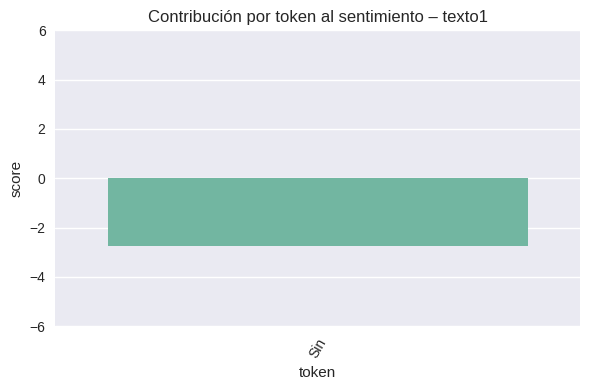

(Aviso) texto2: no hay tokens con adjusted_score != 0 → gráfico omitido.



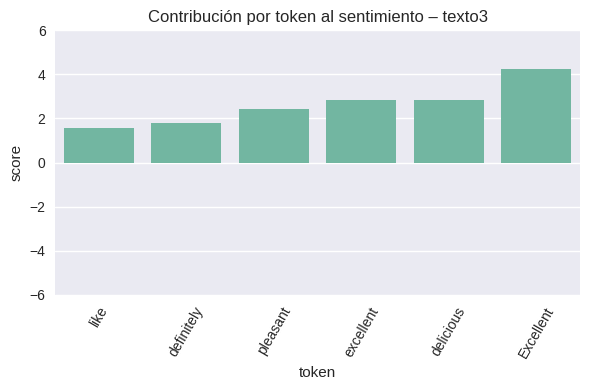

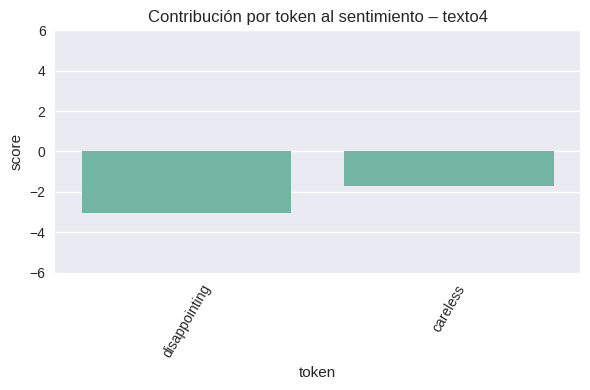

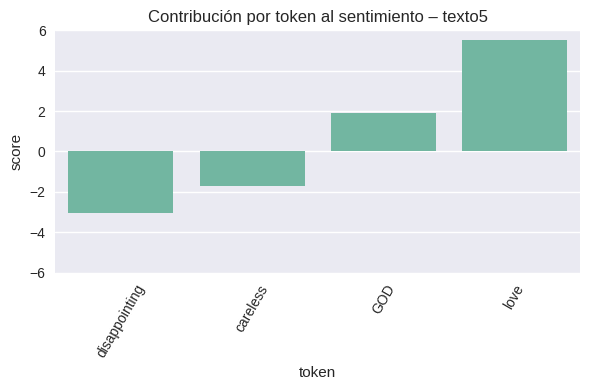

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parámetros globales
Y_MIN, Y_MAX = -6, 6        # Escala vertical común
WIDTH_PER_BAR = 0.7         # ancho base por barra
MIN_WIDTH = 6               # ancho mínimo para evitar gráficos demasiado pequeños

textos = {
    "texto1": texto1,
    "texto2": texto2,
    "texto3": texto3,
    "texto4": texto4,
    "texto5": texto5,
}

for nombre, contenido in textos.items():
    infos, _, _, _ = vader_stepwise(contenido, show_details=False)

    df_tok = pd.DataFrame([
        {"token": inf.token, "score": inf.adjusted_score}
        for inf in infos
        if inf.adjusted_score != 0
    ])

    if df_tok.empty:
        print(f"(Aviso) {nombre}: no hay tokens con adjusted_score != 0 → gráfico omitido.\n")
        continue

    # --- ORDENAR por adjusted_score ---
    df_tok = df_tok.sort_values("score", ascending=True)   # <<< CAMBIAR ascending=False para DESCENDENTE

    # --- Ajustar tamaño horizontal según nº de barras ---
    num_barras = len(df_tok)
    fig_width = max(MIN_WIDTH, num_barras * WIDTH_PER_BAR)

    plt.figure(figsize=(fig_width, 4))
    sns.barplot(data=df_tok, x="token", y="score")

    plt.ylim(Y_MIN, Y_MAX)  # escala vertical común
    plt.title(f"Contribución por token al sentimiento – {nombre}")
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()


- **Radial plot de los tokens con algún peso sentimental**

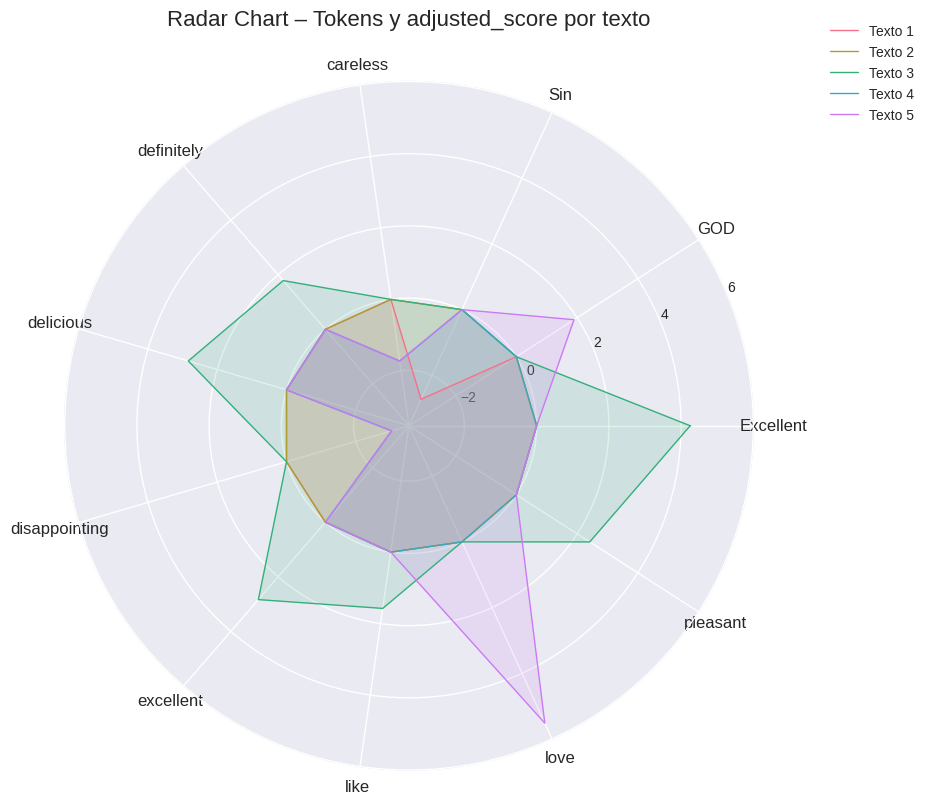

In [58]:
# Obtener datos de adjusted_score sin imprimir tablas
infos1, _, _, _ = vader_stepwise(texto1, show_details=False)
infos2, _, _, _ = vader_stepwise(texto2, show_details=False)
infos3, _, _, _ = vader_stepwise(texto3, show_details=False)
infos4, _, _, _ = vader_stepwise(texto4, show_details=False)
infos5, _, _, _ = vader_stepwise(texto5, show_details=False)

# Convertir a diccionario token → score
def dict_from_infos(infos):
    return {inf.token: inf.adjusted_score for inf in infos if inf.adjusted_score != 0}

d1 = dict_from_infos(infos1)
d2 = dict_from_infos(infos2)
d3 = dict_from_infos(infos3)
d4 = dict_from_infos(infos4)
d5 = dict_from_infos(infos5)

# Conjunto total de tokens relevantes
all_tokens = sorted(set(d1)|set(d2)|set(d3)|set(d4)|set(d5))

# Crear dataframe tokens × textos
df = pd.DataFrame({
    "token": all_tokens,
    "texto1": [d1.get(t, 0) for t in all_tokens],
    "texto2": [d2.get(t, 0) for t in all_tokens],
    "texto3": [d3.get(t, 0) for t in all_tokens],
    "texto4": [d4.get(t, 0) for t in all_tokens],
    "texto5": [d5.get(t, 0) for t in all_tokens],
})

df = df.set_index("token")

# ----- R A D A R   C H A R T -----

labels = df.index.tolist()
num_vars = len(labels)

# Ángulos para el radar chart
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # cerrar círculo

# Crear figura
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Colores seaborn
colors = sns.color_palette("husl", 5)

# Función para trazar cada texto
def add_radar(values, label, color):
    vals = values.tolist()
    vals += vals[:1]  # cerrar forma
    ax.plot(angles, vals, linewidth=1, label=label, color=color)
    ax.fill(angles, vals, alpha=0.15, color=color)

# Agregar líneas para cada texto
add_radar(df["texto1"], "Texto 1", colors[0])
add_radar(df["texto2"], "Texto 2", colors[1])
add_radar(df["texto3"], "Texto 3", colors[2])
add_radar(df["texto4"], "Texto 4", colors[3])
add_radar(df["texto5"], "Texto 5", colors[4])

# Etiquetas en el borde
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)

# Rango uniforme para todos
ax.set_ylim(min(df.min()) - 0.5, max(df.max()) + 0.5)

# Título
# plt.title("Radar Chart – Tokens y adjusted_score por texto", fontsize=16)
plt.title("Radar Chart – Tokens y adjusted_score por texto", fontsize=16, pad=40)
plt.subplots_adjust(top=0.80)

# Leyenda
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))

plt.show()


## Conclusiones

Hemos visto cómo convertir texto en datos, cómo limpiarlo, visualizarlo y analizar su sentimiento.  
También vimos cómo las máquinas interpretan la estructura del lenguaje.

Este cuaderno muestra un flujo básico para análisis exploratorio de texto:  
desde tokenización y frecuencias hasta sentimiento y relaciones entre textos.

Estos métodos son útiles para:
- reseñas  
- encuestas abiertas  
- análisis de redes sociales  
- análisis de artículos o noticias  
- comparaciones entre documentos  
